In [1]:
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from vecstack import stacking
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
from sklearn.linear_model import LogisticRegression
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

rawdata=pd.read_csv("/notebooks/data/onechu/modeling/kwandong/final_plus_rolling_2.csv") #train 데이터 6개월 
rawdata_test=pd.read_csv("/notebooks/data/onechu/modeling/kwandong/churn7_plus_rolling_2.csv")

data=rawdata.copy()
data_test=rawdata_test.copy()

#NULL 값 확인
def check_null(data):
    data=data.fillna(0)
    print('-----------------------------------------------------------------------')
    for feature in data.columns:
        if data[feature].isnull().sum() > 0:
            print('column {} null data count : {}'.format(feature,  data[feature].isnull().sum()))
    return data

data=check_null(data)
data_test=check_null(data_test)

-----------------------------------------------------------------------
-----------------------------------------------------------------------


In [2]:
def make_dummies(what_column,data):
    dummies=pd.get_dummies(data[what_column],prefix=what_column)
    data=pd.concat([data,dummies],axis=1)
    data=data.drop([what_column],axis=1)
    return data

columns_for_dummies=['mno_nm','rf_cluster_num','past_churn','pass_yn','second_cluster_num','DP13_new_dan_yn','DP13_nomal_yn','DP29_yn', 'DP26_yn']

for i in columns_for_dummies:
    data= make_dummies(i,data)
    data_test= make_dummies(i,data_test)

data.info()
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172096 entries, 3140760193836348204-6116017209238797734 to 42789961353743194722733118102945804047
Columns: 137 entries, DP13_dan_count to DP26_yn_1.0
dtypes: float64(72), int64(26), object(2), uint8(37)
memory usage: 138.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 126220 entries, 757347149846607123-7950130419421577724 to -5897613071312040578-1408916646561982150
Columns: 137 entries, DP13_dan_count to DP26_yn_1.0
dtypes: float64(72), int64(26), object(2), uint8(37)
memory usage: 101.7+ MB


In [3]:
#pdp 결과 삭제 목록
#droplist=['cust_payment_amt_min','clsf_new_cat_n' ,'free_pref' , 'sett_target_cpn_amt_var','days_from_register' ,  'DP29_count',  'DP29_nuniq','DP26_amt', 'w2v_prod_clr_6','w2v_prod_clr_9']

droplist=['sex_clsf_cd','age_cat','init_prchs_date','last_prchs_date']
"""
data
""" 

dropped_data = data.drop(droplist, axis=1)
X=dropped_data.drop(['churn'], axis=1)
y=dropped_data['churn']

#val 비율 8:2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0) # 이전 0
X_train.shape, X_val.shape
"""
data_val
"""
dropped_data_test = data_test.drop(droplist, axis=1)
X_test=dropped_data_test.drop(['churn'], axis=1)
y_test=dropped_data_test['churn']

array([1., 1., 1., ..., 1., 1., 1.])

Accuracy:  0.8800697269029634
              precision    recall  f1-score   support

         0.0       0.80      0.70      0.75      8713
         1.0       0.90      0.94      0.92     25707

    accuracy                           0.88     34420
   macro avg       0.85      0.82      0.83     34420
weighted avg       0.88      0.88      0.88     34420



Text(0.5, 0, 'False Positive Rate')

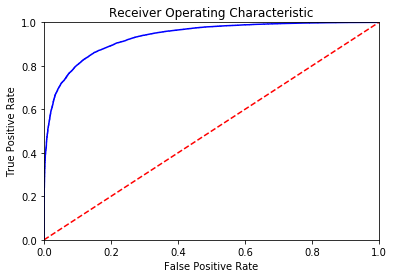

In [4]:
from sklearn.metrics import classification_report
"""

6개월 train 데이터 8:2 train: val 

"""
# 랜덤 포레스트
RF= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features=11, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

RF.fit(X_train, y_train) 

# Make predictions
predictions = RF.predict(X_val)
probs = RF.predict_proba(X_val)
display(predictions)

score = RF.score(X_val, y_val)
print("Accuracy: ", score)
print(classification_report(y_val, predictions))
data['churn'].value_counts()

# get_ipython().magic('matplotlib inline')
# confusion_matrix = pd.DataFrame(
#     confusion_matrix(y_val, predictions), 
#     columns=["Predicted False", "Predicted True"], 
#     index=["Actual False", "Actual True"]
# )
# display(confusion_matrix)

#ROC 커브 그리기
fpr, tpr, threshold = roc_curve(y_val, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

array([0., 0., 1., ..., 1., 1., 1.])

Accuracy:  0.8266598003485977
              precision    recall  f1-score   support

         0.0       0.84      0.61      0.71     43233
         1.0       0.82      0.94      0.88     82987

    accuracy                           0.83    126220
   macro avg       0.83      0.78      0.79    126220
weighted avg       0.83      0.83      0.82    126220



Text(0.5, 0, 'False Positive Rate')

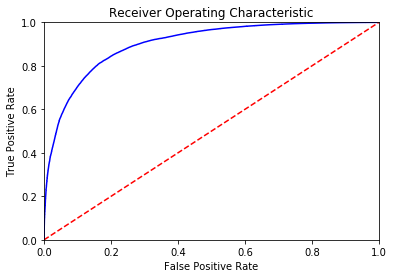

In [5]:
"""

3개월 test 데이터 

"""

predictions = RF.predict(X_test)
probs = RF.predict_proba(X_test)
display(predictions)
score = RF.score(X_test, y_test)
print("Accuracy: ", score)
print(classification_report(y_test, predictions))
data_test['churn'].value_counts()

# get_ipython().magic('matplotlib inline')
# confusion_matrix = pd.DataFrame(
#     confusion_matrix(y_test, predictions), 
#     columns=["Predicted False", "Predicted True"], 
#     index=["Actual False", "Actual True"]
# )
# display(confusion_matrix)

#confusion_matrix(y_test, predictions)

# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


array([1., 1., 1., ..., 1., 1., 1.])

Accuracy:  0.8885241138872748
              precision    recall  f1-score   support

         0.0       0.82      0.72      0.77      8713
         1.0       0.91      0.95      0.93     25707

    accuracy                           0.89     34420
   macro avg       0.86      0.83      0.85     34420
weighted avg       0.89      0.89      0.89     34420



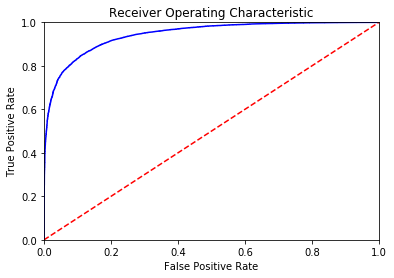

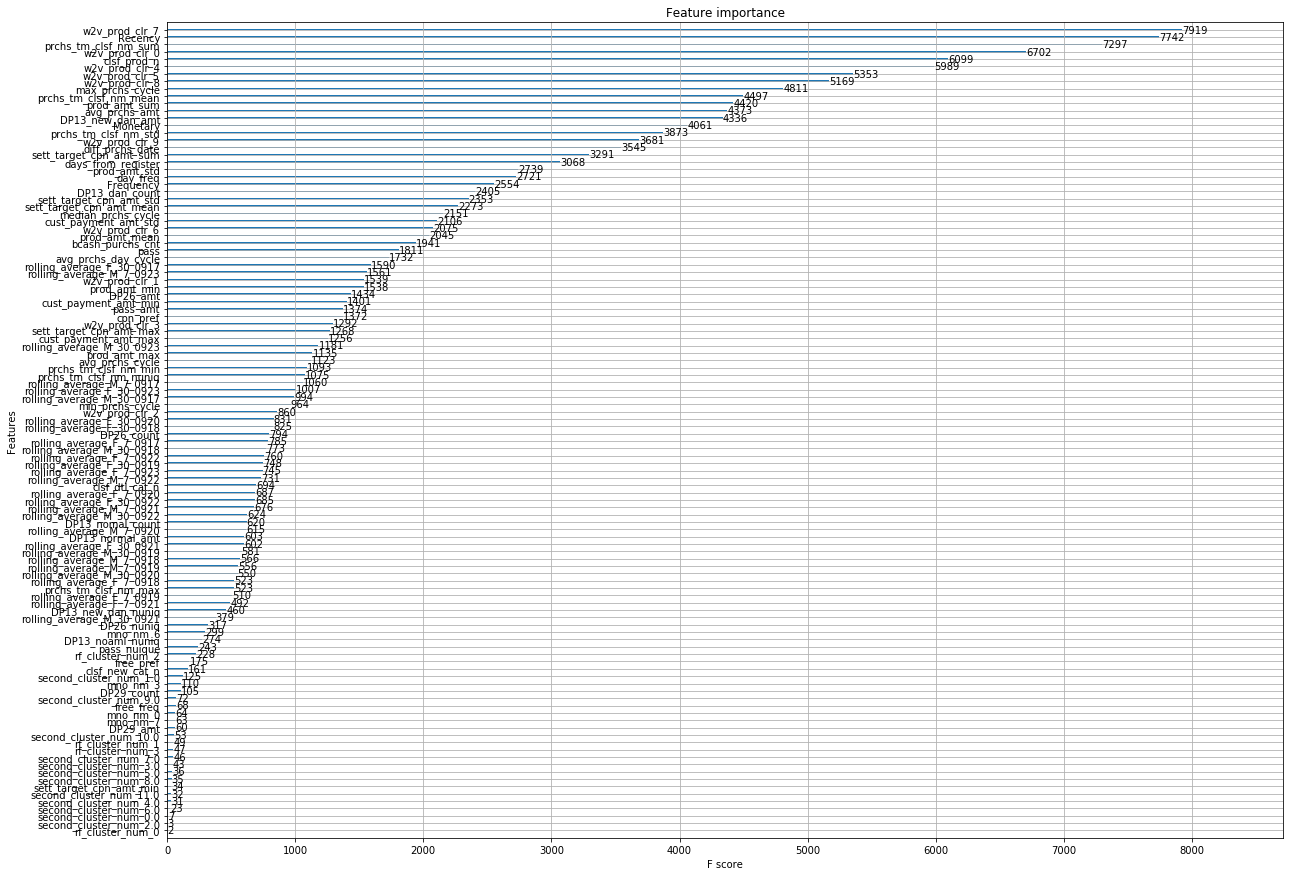

In [6]:
from sklearn.metrics import classification_report
from xgboost import plot_importance
"""

6개월 train 데이터 8:2 train: val 

"""
#feature importance 뽑기 위해 xg
#XGB=XGBClassifier(n_jobs=-1,Eta=0.1,min_child_weight=3, n_estimators=10, max_depth=3, random_state=0 )
# XGB=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
#               learning_rate=0.05, max_delta_step=0, max_depth=5,
#               min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
#               nthread=-1, objective='binary:logistic', random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=10,
#               silent=None, subsample=0.8, verbosity=1)
#XGB= xgb.XGBClassifier( leaning_rate= 0.02, max_bin=10,num_leaves=16, subsample=0.7, max_depth=4, subsample_freq=2, colsample_bytree= 0.3, min_child_samples=500,seed=99,n_estimators=300, objective= 'binary:logistic',n_jobs=-1)
XGB=XGBClassifier(gamma=0.1, subsmaple=1.0, colsample_bytree=1.0, n_estimators=500,max_depth=10, min_child_weight=10, learning_rate=0.01, objective= 'binary:logistic', n_jobs=-1)
XGB.fit(X_train, y_train) 

# Make predictions
predictions = XGB.predict(X_val)
probs = XGB.predict_proba(X_val)
display(predictions)

score = XGB.score(X_val, y_val)
print("Accuracy: ", score)
print(classification_report(y_val, predictions))
data['churn'].value_counts()


# confusion_matrix(y_val, predictions)
# display(confusion_matrix)

#ROC 커브 그리기
fpr, tpr, threshold = roc_curve(y_val, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# feature importance - F score XG꺼 씀
fig, ax = plt.subplots(figsize=(20,15))
plot_importance(XGB, ax=ax)

array([0., 0., 1., ..., 1., 1., 1.])

Accuracy:  0.8035255902392647
              precision    recall  f1-score   support

         0.0       0.89      0.49      0.63     43233
         1.0       0.78      0.97      0.87     82987

    accuracy                           0.80    126220
   macro avg       0.84      0.73      0.75    126220
weighted avg       0.82      0.80      0.79    126220



Text(0.5, 0, 'False Positive Rate')

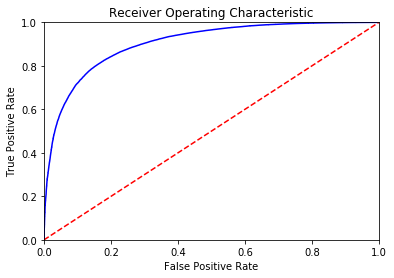

In [7]:
"""

3개월 test 데이터 

"""

predictions = XGB.predict(X_test)
probs = XGB.predict_proba(X_test)
display(predictions)
score = XGB.score(X_test, y_test)
print("Accuracy: ", score)
print(classification_report(y_test, predictions))
data_test['churn'].value_counts()

# get_ipython().magic('matplotlib inline')
# confusion_matrix = pd.DataFrame(
#     confusion_matrix(y_test, predictions), 
#     columns=["Predicted False", "Predicted True"], 
#     index=["Actual False", "Actual True"]
# )
# display(confusion_matrix)

#confusion_matrix(y_test, predictions)

# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [42]:
# models = [
# #     RandomForestClassifier(random_state=0, n_jobs=-1, 
# #                            n_estimators=100, max_depth=3),
#     RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                        max_depth=None, max_features=30, max_leaf_nodes=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=500,
#                        n_jobs=-1, oob_score=False, random_state=42, verbose=0,
#                        warm_start=False),

# #    XGBClassifier(n_jobs=-1,Eta=0.1,min_child_weight=3, n_estimators=10, max_depth=3, random_state=0 ),
#     XGBClassifier(gamma=0.1, subsmaple=1.0, colsample_bytree=1.0, n_estimators=500,max_depth=10, min_child_weight=10, learning_rate=0.01, objective= 'binary:logistic', n_jobs=-1),
    
#     LogisticRegression(C= 1.0, max_iter= 140, dual= False,n_jobs=-1)

 
# ]

# S_train, S_test = stacking(models,                   
#                            #X_train, y_train, X_test, 
#                            X_train, y_train, X_test,
#                            regression=False, 
     
#                            mode='oof_pred_bag', 
       
#                            needs_proba=False,
         
#                            save_dir=None, 
            
#                            metric=accuracy_score, 
    
#                            n_folds=2,  #몇번 실행 많이 실행 할수록 좋아지나 오래걸린다. 
                 
#                            stratified=True,
            
#                            shuffle=True,  
            
#                            random_state=0,    
         
#                            verbose=2)
models = [
#     RandomForestClassifier(random_state=0, n_jobs=-1, 
#                            n_estimators=100, max_depth=3),
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=30, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False),

#    XGBClassifier(n_jobs=-1,Eta=0.1,min_child_weight=3, n_estimators=10, max_depth=3, random_state=0 ),
    XGBClassifier(gamma=0.1, subsmaple=1.0, colsample_bytree=1.0, n_estimators=500,max_depth=10, min_child_weight=10, learning_rate=0.01, objective= 'binary:logistic', n_jobs=-1),
    
    LogisticRegression(C= 1.0, max_iter= 140, dual= False,n_jobs=-1)

 
]

S_train, S_test = stacking(models,                   
                          
                           X_train, y_train, X_test,
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=2,  #바꿔 볼 가치 있는듯?
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    fold  0:  [0.88150440]
    fold  1:  [0.88374154]
    ----
    MEAN:     [0.88262297] + [0.00111857]
    FULL:     [0.88262297]

model  1:     [XGBClassifier]
    fold  0:  [0.88337837]
    fold  1:  [0.88557192]
    ----
    MEAN:     [0.88447514] + [0.00109678]
    FULL:     [0.88447514]

model  2:     [LogisticRegression]


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


    fold  0:  [0.82002673]


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


    fold  1:  [0.82194427]
    ----
    MEAN:     [0.82098550] + [0.00095877]
    FULL:     [0.82098550]



/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [43]:
model = XGBClassifier(gamma=0.1, subsmaple=1.0, colsample_bytree=1.0, n_estimators=500,max_depth=10, min_child_weight=10, learning_rate=0.01, objective= 'binary:logistic', n_jobs=-1)
    
model = model.fit(S_train, y_train)
y_pred = model.predict(S_test)
print('Final accuracy_score: [%.4f]' % accuracy_score(y_test, y_pred))

Final accuracy_score: [0.8401]


              precision    recall  f1-score   support

         0.0       0.83      0.67      0.74     43233
         1.0       0.84      0.93      0.88     82987

    accuracy                           0.84    126220
   macro avg       0.84      0.80      0.81    126220
weighted avg       0.84      0.84      0.84    126220



Text(0.5, 0, 'False Positive Rate')

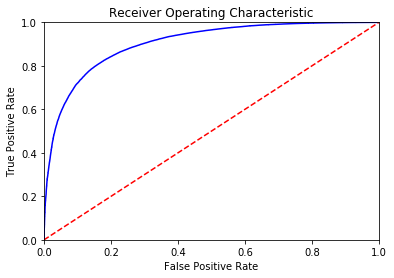

In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

파라미터 튜닝을 해보자

In [ ]:
# 그리드로 큰 틀 잡기 
from sklearn.model_selection import GridSearchCV
 
param_grid = [{'n_estimators': [300], 'max_depth':[10,15], 'min_samples_leaf':[1,2], 'max_features': [11], 'bootstrap': [True, False],'random_state': [0,20,42], 'n_jobs':[-1]}]
RF_G = RandomForestClassifier()
grid_search = GridSearchCV(RF_G, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)
RF_G = grid_search.best_estimator_
RF_G

In [ ]:
#랜덤으로 세부 조정 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

RF_R = RandomForestClassifier()
param_dist = {"max_depth": [10, 20],
              "max_features": sp_randint(1, 15),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False]
             }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(RF_R, param_distributions=param_dist,
                                   n_iter=n_iter_search)

In [ ]:
random_search.fit(X_train, y_train)
RF_R = grid_search.best_estimator_
RF_R

LIME을 그려보자 

In [11]:
import lime
import lime.lime_tabular

predict_fn_rf = lambda X_test: RF.predict_proba(X_test).astype(float)
X_values = X_test.values
explainer = lime.lime_tabular.LimeTabularExplainer(X_values,feature_names = X_test.columns,class_names=['잔존','이탈'],kernel_width=100)

In [12]:
#3개월치 테스트 데이터 new_id 보기
X_test.index.tolist()


['757347149846607123-7950130419421577724',
 '5830095042816988293-1515297181624293204',
 '834687936733873256-3499315498174639934',
 '70634120474938090658356630735319080925',
 '6048148701871482738-7259703634351159847',
 '61504318719731561446170690246070166196',
 '2081922843865592326801604080090084151',
 '6544799094004153212-1120310038964645711',
 '-61832588705808081276584799826636765784',
 '5249909961468145267-6529185500430151791',
 '-7090937614324514592-5158085185760117244',
 '8731863621631230100-7007301947942640768',
 '-3378813486002990522-3063412690721501515',
 '-2418055549511557325-8690611606841723182',
 '-349831013117920551-4736213441713924324',
 '-57144749641524954488611895424967440298',
 '12687120500335763764706742828140823123',
 '7081531861221784438457071465589188440',
 '3200231420695955145-7208730127342470371',
 '8636740792139405057-5642319270849865515',
 '8930583601406097802-5451573784876579932',
 '5691200415294228136-8331640635531616874',
 '394456789092168061-88555398386906994

In [13]:
#확인해볼 타겟 new_id(한 사람)
target_id = '8256356212841621953-4779977290935141705'

In [14]:
#3개월치 테스트 데이터 new_id 하나 골라서 values보기
X_test.loc[[target_id ]]

,DP13_dan_count,DP13_new_dan_amt,DP13_new_dan_nuniq,DP13_noaml_nuniq,DP13_nomal_count,DP13_normal_amt,DP26_amt,DP26_count,DP26_nuniq,DP29_amt,...,second_cluster_num_10.0,second_cluster_num_11.0,DP13_new_dan_yn_0.0,DP13_new_dan_yn_1.0,DP13_nomal_yn_0.0,DP13_nomal_yn_1.0,DP29_yn_0.0,DP29_yn_1.0,DP26_yn_0.0,DP26_yn_1.0
8256356212841621953-4779977290935141705,401.0,51425.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,1,0,1,0


In [15]:
#3개월치 테스트 데이터 new_id 하나 골라서 churn보기
y_test.loc[[target_id]]

8256356212841621953-4779977290935141705    1.0
Name: churn, dtype: float64

In [16]:
choosen_instance = X_test.loc[[target_id]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=100)
exp.show_in_notebook(show_all=False)

이동평균 구하기 - make feature 

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 함수화 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 6개월

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline



data = pd.read_csv('/notebooks/data/onechu/Original_Data(do_not_touch)/ebook_20180101_20180630_2.csv.gz',usecols=['prchs_id','partition_dt','prod_amt','insd_usermbr_no','insd_device_id']) #partition_dt

#data.info()

data['new_id'] = data["insd_usermbr_no"].astype('str') + data["insd_device_id"].astype('str')
del data["insd_usermbr_no"]
del data["insd_device_id"]


pd.to_datetime(data['partition_dt'])
data=data.sort_values(by='partition_dt')
id_data= data['new_id']
id_data=id_data.drop_duplicates()
id_data

data.index=data['new_id']
data=data.drop('new_id',axis=1)
rawdata=data.copy()
# data.index=data['new_id']
# data=data.drop('new_id',axis=1)

data=pd.pivot_table(data,index="new_id",columns='partition_dt',values='prod_amt')
data= data.T
#data_p= data.pivot(index='new_id',columns='partition_dt',values='prod_amt')
#data=data.fillna(0)
data_7mean = data.rolling(window=7,min_periods=1).mean()
data_7mean=data_7mean.T
rol_avg_amt_7days=data_7mean.iloc[:, 167:174 ] #175:181

data_30mean = data.rolling(window=30,min_periods=1).mean()
data_30mean=data_30mean.T
data_30mean=data_30mean.iloc[:, 167:174 ]
# 167, 174 17일 ~ 23일
data=pd.read_csv("/notebooks/data/onechu/churn/churn7_train_0825.csv") #partition_dt
#data.set_index('new_id',inplace=True)
#!!!!!!!!!!!!!

rol_avg_amt_7days.rename(columns = {20180617: "rolling_average_M_7_day17"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180618: "rolling_average_M_7_day18"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180619: "rolling_average_M_7_day19"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180620: "rolling_average_M_7_day20"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180621: "rolling_average_M_7_day21"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180622: "rolling_average_M_7_day22"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180623: "rolling_average_M_7_day23"}, inplace = True)
result = pd.merge(data,rol_avg_amt_7days,right_index=True,left_index=True)



data_30mean.rename(columns = {20180617: "rolling_average_M_30_day17"}, inplace = True)
data_30mean.rename(columns = {20180618: "rolling_average_M_30_day18"}, inplace = True)
data_30mean.rename(columns = {20180619: "rolling_average_M_30_day19"}, inplace = True)
data_30mean.rename(columns = {20180620: "rolling_average_M_30_day20"}, inplace = True)
data_30mean.rename(columns = {20180621: "rolling_average_M_30_day21"}, inplace = True)
data_30mean.rename(columns = {20180622: "rolling_average_M_30_day22"}, inplace = True)
data_30mean.rename(columns = {20180623: "rolling_average_M_30_day23"}, inplace = True)
result = pd.merge(result,data_30mean,right_index=True,left_index=True)

result.to_csv('final_plus_rolling_pre.csv',index_label=False)
data = pd.read_csv('final_plus_rolling_pre.csv') #partition_dt
fre_data=pd.pivot_table(rawdata,index="new_id",columns='partition_dt',values='prchs_id', aggfunc="count")

fre_data=fre_data.T
data_7mean = fre_data.rolling(window=7,min_periods=1).mean()
data_7mean = data_7mean.T

rol_avg_freq_7days=data_7mean.iloc[:, 167:174 ]

rol_avg_freq_7days.rename(columns = {20180617: "rolling_average_F_7_day17"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180618: "rolling_average_F_7_day18"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180619: "rolling_average_F_7_day19"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180620: "rolling_average_F_7_day20"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180621: "rolling_average_F_7_day21"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180622: "rolling_average_F_7_day22"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180623: "rolling_average_F_7_day23"}, inplace = True)
result = pd.merge(data,rol_avg_freq_7days,right_index=True,left_index=True)
data_30mean = fre_data.rolling(window=30,min_periods=1).mean()
data_30mean=data_30mean.T
data_30mean=data_30mean.iloc[:, 167:174 ]


data_30mean.rename(columns = {20180617: "rolling_average_F_30_day17"}, inplace = True)
data_30mean.rename(columns = {20180618: "rolling_average_F_30_day18"}, inplace = True)
data_30mean.rename(columns = {20180619: "rolling_average_F_30_day19"}, inplace = True)
data_30mean.rename(columns = {20180620: "rolling_average_F_30_day20"}, inplace = True)
data_30mean.rename(columns = {20180621: "rolling_average_F_30_day21"}, inplace = True)
data_30mean.rename(columns = {20180622: "rolling_average_F_30_day22"}, inplace = True)
data_30mean.rename(columns = {20180623: "rolling_average_F_30_day23"}, inplace = True)
result = pd.merge(result,data_30mean,right_index=True,left_index=True)


#data.set_index('new_id',inplace=True)


#result
result.to_csv('final_plus_rolling.csv',index_label=False)


In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 함수화 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 3개월

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline



data = pd.read_csv('/notebooks/data/onechu/Original_Data(do_not_touch)/ebook_20180701_20180931_2.csv.gz',usecols=['prchs_id','partition_dt','prod_amt','insd_usermbr_no','insd_device_id']) #partition_dt

#data.info()

data['new_id'] = data["insd_usermbr_no"].astype('str') + data["insd_device_id"].astype('str')
del data["insd_usermbr_no"]
del data["insd_device_id"]


pd.to_datetime(data['partition_dt'])
data=data.sort_values(by='partition_dt')
id_data= data['new_id']
id_data=id_data.drop_duplicates()
id_data

data.index=data['new_id']
data=data.drop('new_id',axis=1)
rawdata=data.copy()
# data.index=data['new_id']
# data=data.drop('new_id',axis=1)

data=pd.pivot_table(data,index="new_id",columns='partition_dt',values='prod_amt')
data= data.T
#data_p= data.pivot(index='new_id',columns='partition_dt',values='prod_amt')
#data=data.fillna(0)
data_7mean = data.rolling(window=7,min_periods=1).mean()
data_7mean=data_7mean.T
rol_avg_amt_7days=data_7mean.iloc[:, 78:85 ] #175:181

data_30mean = data.rolling(window=30,min_periods=1).mean()
data_30mean=data_30mean.T
data_30mean=data_30mean.iloc[:, 78:85 ]
# 167, 174
data = pd.read_csv('../churn/churn7_test.csv') #partition_dt
#data.set_index('new_id',inplace=True)
#!!!!!!!!!!!!!

rol_avg_amt_7days.rename(columns = {20180917: "rolling_average_M_7_day17"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180918: "rolling_average_M_7_day18"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180919: "rolling_average_M_7_day19"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180920: "rolling_average_M_7_day20"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180921: "rolling_average_M_7_day21"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180922: "rolling_average_M_7_day22"}, inplace = True)
rol_avg_amt_7days.rename(columns = {20180923: "rolling_average_M_7_day23"}, inplace = True)
result = pd.merge(data,rol_avg_amt_7days,right_index=True,left_index=True)



data_30mean.rename(columns = {20180917: "rolling_average_M_30_day17"}, inplace = True)
data_30mean.rename(columns = {20180918: "rolling_average_M_30_day18"}, inplace = True)
data_30mean.rename(columns = {20180919: "rolling_average_M_30_day19"}, inplace = True)
data_30mean.rename(columns = {20180920: "rolling_average_M_30_day20"}, inplace = True)
data_30mean.rename(columns = {20180921: "rolling_average_M_30_day21"}, inplace = True)
data_30mean.rename(columns = {20180922: "rolling_average_M_30_day22"}, inplace = True)
data_30mean.rename(columns = {20180923: "rolling_average_M_30_day23"}, inplace = True)
result = pd.merge(result,data_30mean,right_index=True,left_index=True)

result.to_csv('churn7_plus_rolling_pre.csv',index_label=False)
data = pd.read_csv('churn7_plus_rolling_pre.csv') #partition_dt
fre_data=pd.pivot_table(rawdata,index="new_id",columns='partition_dt',values='prchs_id', aggfunc="count")

fre_data=fre_data.T
data_7mean = fre_data.rolling(window=7,min_periods=1).mean()
data_7mean = data_7mean.T

rol_avg_freq_7days=data_7mean.iloc[:, 78:85 ]

rol_avg_freq_7days.rename(columns = {20180917: "rolling_average_F_7_day17"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180918: "rolling_average_F_7_day18"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180919: "rolling_average_F_7_day19"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180920: "rolling_average_F_7_day20"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180921: "rolling_average_F_7_day21"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180922: "rolling_average_F_7_day22"}, inplace = True)
rol_avg_freq_7days.rename(columns = {20180923: "rolling_average_F_7_day23"}, inplace = True)
result = pd.merge(data,rol_avg_freq_7days,right_index=True,left_index=True)
data_30mean = fre_data.rolling(window=30,min_periods=1).mean()
data_30mean=data_30mean.T
data_30mean=data_30mean.iloc[:, 78:85 ]


data_30mean.rename(columns = {20180917: "rolling_average_F_30_day17"}, inplace = True)
data_30mean.rename(columns = {20180918: "rolling_average_F_30_day18"}, inplace = True)
data_30mean.rename(columns = {20180919: "rolling_average_F_30_day19"}, inplace = True)
data_30mean.rename(columns = {20180920: "rolling_average_F_30_day20"}, inplace = True)
data_30mean.rename(columns = {20180921: "rolling_average_F_30_day21"}, inplace = True)
data_30mean.rename(columns = {20180922: "rolling_average_F_30_day22"}, inplace = True)
data_30mean.rename(columns = {20180923: "rolling_average_F_30_day23"}, inplace = True)

result = pd.merge(result,data_30mean,right_index=True,left_index=True)


#data.set_index('new_id',inplace=True)


#result
result.to_csv('churn7_plus_rolling.csv',index_label=False)
